In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
from tqdm import tqdm
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import scipy.stats as stats
import statsmodels.stats.multicomp as mc
from scipy.stats import normaltest
from scipy.stats import shapiro
import scikit_posthocs as sp
import statsmodels.api as sm
from statsmodels.formula.api import ols
import math
import os

# CMA aging Atlas: Kidney
Data downloaded from [Tabula muris senis](https://cellxgene.cziscience.com/collections/0b9d8a04-bb9d-44da-aa27-705bb65b54eb) project. Muscle data, Smart-seq2 assay in .h5ad format was used for further analysis.

In [2]:
# Creating folder for outputs
os.makedirs('../Khwaja_et_al_outputs/Muscle')

## Importing and preprocessing data

In [3]:
# Import h5ad file in scanpy. 
adata = sc.read_h5ad('../Exp. 2_Tabula muris/Files/TM_muscle_smartseq.h5ad')

# Normalize as CPM (counts per million)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e6)

# Transforming CPM into log form
sc.pp.log1p(adata)

## CMA score calculation

In [5]:
# Load matrix file with weight and direction 
model_matrix = pd.read_excel('../Exp. 2_Tabula muris/activation_model.xlsx')

# Removing EEF1A1 and RAC1 genes because they don't appear in the adata
model_matrix = model_matrix.drop([6, 8], axis=0).reset_index()

# Finding CMA network genes in the dataset
cma_network = adata[:, model_matrix["Ensembl_ms"]]

# Calculating the Zs scores
cma_data_zs = cma_network.copy().X.todense().T

for i in tqdm(np.arange(cma_data_zs.shape[0])):
    
    µ = np.mean(cma_data_zs[i, :])
    sd = np.std(cma_data_zs[i, :])
    
    cma_data_zs[i, :] = (cma_data_zs[i, :] - µ)/sd
    
# Generating a copy of adata.obs to work with
barcode = adata.obs.copy()

# New column in barcode (aka adata.obs) with the CMA scores for each cell detected
for i,j in tqdm(enumerate(barcode.index)):
        
    cell_matrix = model_matrix.copy()

    for g in cell_matrix.index:

        cell_matrix.loc[g, 'gene_count'] = cma_data_zs[g, i]

    cell_matrix['gene_score'] = cell_matrix['gene_count'] * cell_matrix['Direction'] * cell_matrix['Weight']
    score = cell_matrix['gene_score'].sum()/np.sum(cell_matrix['Weight'])

    barcode.loc[j, 'score'] = score   
    

100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 1025.14it/s]
3855it [00:15, 247.72it/s]


In [6]:
barcode.head()

,FACS.selection,age,cell,free_annotation,method,mouse.id,subtissue,n_genes,n_counts,louvain,...,organism_ontology_term_id,cell_type,assay,disease,organism,sex,tissue,ethnicity,development_stage,score
index,,,,,,,,,,,,,,,,,,,,,
A10_B000927_B007456_S10.mm10-plus-0-0,"CD31+, CD45+, CD31-CD45-Sca1+, CD31-CD45-Sca1-...",18m,A10_B000927,nan,facs,18_46_F,Muscle Diaphragm,2789,2356.270020,1,...,NCBITaxon:10090,skeletal muscle satellite cell,Smart-seq2,normal,Mus musculus,female,limb muscle,na,18 month-old stage,-0.211785
A10_B003294_B007450_S10.mm10-plus-0-0,"CD31+, CD45+, CD31-CD45-Sca1+, CD31-CD45-Sca1-...",18m,A10_B003294,nan,facs,18_47_F,Muscle forelimb and hindlimb,1838,3657.208008,0,...,NCBITaxon:10090,skeletal muscle satellite cell,Smart-seq2,normal,Mus musculus,female,limb muscle,na,18 month-old stage,0.084253
A11_B000927_B007456_S11.mm10-plus-0-0,"CD31+, CD45+, CD31-CD45-Sca1+, CD31-CD45-Sca1-...",18m,A11_B000927,nan,facs,18_46_F,Muscle Diaphragm,3198,2857.186279,7,...,NCBITaxon:10090,skeletal muscle satellite cell,Smart-seq2,normal,Mus musculus,female,limb muscle,na,18 month-old stage,-0.027031
A11_B003263_B007458_S11.mm10-plus-0-0,"CD31+, CD45+, CD31-CD45-Sca1+, CD31-CD45-Sca1-...",18m,A11_B003263,nan,facs,18_45_M,forelimb and hindlimb,1082,2264.398682,1,...,NCBITaxon:10090,skeletal muscle satellite cell,Smart-seq2,normal,Mus musculus,male,limb muscle,na,18 month-old stage,0.134997
A11_B003294_B007450_S11.mm10-plus-0-0,"CD31+, CD45+, CD31-CD45-Sca1+, CD31-CD45-Sca1-...",18m,A11_B003294,nan,facs,18_47_F,Muscle forelimb and hindlimb,1218,2633.463135,8,...,NCBITaxon:10090,skeletal muscle satellite cell,Smart-seq2,normal,Mus musculus,female,limb muscle,na,18 month-old stage,-0.181882


## CMA net score/cell type (fold over whole tissue)

In [7]:
# Checking n of mice 
print(list(barcode['mouse.id'].unique()))

['18_46_F', '18_47_F', '18_45_M', '18_53_M', '24_59_M', '24_58_M', '24_60_M', '24_61_M', '3_38_F', '3_11_M', '3_8_M', '3_39_F', '3_10_M', '3_9_M']


**Mice n for Liver**
    - Young females: 2
    - Young males: 4
    - Old females: 2
    - Old males: 6

In [8]:
print(list(barcode.cell_type.unique()))

['skeletal muscle satellite cell', 'T cell', 'mesenchymal stem cell', 'macrophage', 'endothelial cell', 'B cell']


In [9]:
# Generating new ages
for j in tqdm(barcode.index):    
    if barcode.loc[j, 'age'] == '3m':        
        barcode.loc[j, 'new_age'] = '3m'

    else:                
        barcode.loc[j, 'new_age'] = '18-24m'
        
for j in tqdm(barcode.index):    
    if barcode.loc[j, 'cell_type'] == 'skeletal muscle satellite cell':        
        barcode.loc[j, 'new_cell'] = 'satellite cell'
    
    else:                
        barcode.loc[j, 'new_cell'] = barcode.loc[j, 'cell_type']


barcode.head()

100%|████████████████████████████████████████████████████████████████████████████| 3855/3855 [00:00<00:00, 6757.36it/s]


,FACS.selection,age,cell,free_annotation,method,mouse.id,subtissue,n_genes,n_counts,louvain,...,assay,disease,organism,sex,tissue,ethnicity,development_stage,score,new_age,new_cell
index,,,,,,,,,,,,,,,,,,,,,
A10_B000927_B007456_S10.mm10-plus-0-0,"CD31+, CD45+, CD31-CD45-Sca1+, CD31-CD45-Sca1-...",18m,A10_B000927,nan,facs,18_46_F,Muscle Diaphragm,2789,2356.270020,1,...,Smart-seq2,normal,Mus musculus,female,limb muscle,na,18 month-old stage,-0.211785,18-24m,satellite cell
A10_B003294_B007450_S10.mm10-plus-0-0,"CD31+, CD45+, CD31-CD45-Sca1+, CD31-CD45-Sca1-...",18m,A10_B003294,nan,facs,18_47_F,Muscle forelimb and hindlimb,1838,3657.208008,0,...,Smart-seq2,normal,Mus musculus,female,limb muscle,na,18 month-old stage,0.084253,18-24m,satellite cell
A11_B000927_B007456_S11.mm10-plus-0-0,"CD31+, CD45+, CD31-CD45-Sca1+, CD31-CD45-Sca1-...",18m,A11_B000927,nan,facs,18_46_F,Muscle Diaphragm,3198,2857.186279,7,...,Smart-seq2,normal,Mus musculus,female,limb muscle,na,18 month-old stage,-0.027031,18-24m,satellite cell
A11_B003263_B007458_S11.mm10-plus-0-0,"CD31+, CD45+, CD31-CD45-Sca1+, CD31-CD45-Sca1-...",18m,A11_B003263,nan,facs,18_45_M,forelimb and hindlimb,1082,2264.398682,1,...,Smart-seq2,normal,Mus musculus,male,limb muscle,na,18 month-old stage,0.134997,18-24m,satellite cell
A11_B003294_B007450_S11.mm10-plus-0-0,"CD31+, CD45+, CD31-CD45-Sca1+, CD31-CD45-Sca1-...",18m,A11_B003294,nan,facs,18_47_F,Muscle forelimb and hindlimb,1218,2633.463135,8,...,Smart-seq2,normal,Mus musculus,female,limb muscle,na,18 month-old stage,-0.181882,18-24m,satellite cell


In [10]:
# Calculation of net score to 3m using whole tissue CMA score mean
µ = np.mean(barcode[barcode['new_age'] == '3m']['score'])

for i in barcode.index:
    barcode.loc[i, 'net_score'] = barcode.loc[i, 'score'] - µ 

barcode.head()

,FACS.selection,age,cell,free_annotation,method,mouse.id,subtissue,n_genes,n_counts,louvain,...,disease,organism,sex,tissue,ethnicity,development_stage,score,new_age,new_cell,net_score
index,,,,,,,,,,,,,,,,,,,,,
A10_B000927_B007456_S10.mm10-plus-0-0,"CD31+, CD45+, CD31-CD45-Sca1+, CD31-CD45-Sca1-...",18m,A10_B000927,nan,facs,18_46_F,Muscle Diaphragm,2789,2356.270020,1,...,normal,Mus musculus,female,limb muscle,na,18 month-old stage,-0.211785,18-24m,satellite cell,-0.293106
A10_B003294_B007450_S10.mm10-plus-0-0,"CD31+, CD45+, CD31-CD45-Sca1+, CD31-CD45-Sca1-...",18m,A10_B003294,nan,facs,18_47_F,Muscle forelimb and hindlimb,1838,3657.208008,0,...,normal,Mus musculus,female,limb muscle,na,18 month-old stage,0.084253,18-24m,satellite cell,0.002932
A11_B000927_B007456_S11.mm10-plus-0-0,"CD31+, CD45+, CD31-CD45-Sca1+, CD31-CD45-Sca1-...",18m,A11_B000927,nan,facs,18_46_F,Muscle Diaphragm,3198,2857.186279,7,...,normal,Mus musculus,female,limb muscle,na,18 month-old stage,-0.027031,18-24m,satellite cell,-0.108351
A11_B003263_B007458_S11.mm10-plus-0-0,"CD31+, CD45+, CD31-CD45-Sca1+, CD31-CD45-Sca1-...",18m,A11_B003263,nan,facs,18_45_M,forelimb and hindlimb,1082,2264.398682,1,...,normal,Mus musculus,male,limb muscle,na,18 month-old stage,0.134997,18-24m,satellite cell,0.053676
A11_B003294_B007450_S11.mm10-plus-0-0,"CD31+, CD45+, CD31-CD45-Sca1+, CD31-CD45-Sca1-...",18m,A11_B003294,nan,facs,18_47_F,Muscle forelimb and hindlimb,1218,2633.463135,8,...,normal,Mus musculus,female,limb muscle,na,18 month-old stage,-0.181882,18-24m,satellite cell,-0.263203


In [11]:
cells = ['satellite cell']

### Cell types stats

In [12]:
# Function for testing normality using D'Agostino-Pearson of different cell types and ages
def normalidad (df, tipo, años):
    long = []
    cell = []
    age = []
    estadistica=[]
    pval=[]
    result=[]   
    
    for x in tipo:
        for y in años:
            mydata = df[(df['new_cell']== x) & (df['new_age']== y)]
            n = len(mydata.index)
            data = list(mydata.net_score)            
            stat, p = normaltest(data)
            long.append(n)
            cell.append(x)
            age.append(y)
            estadistica.append(stat)
            pval.append(p)
            if p > 0.05:
                result.append("Normal")
            else:
                result.append("Not normal")    
    df_norm = pd.DataFrame({"Cell": cell, "Age": age, "n": long, "Stat":estadistica, "p value": pval, "Result":result})
    return(df_norm)

In [13]:
normalidad(barcode, tipo=cells, años=['3m', '18-24m'])

,Cell,Age,n,Stat,p value,Result
0,satellite cell,3m,535,23.953656,0.000006,Not normal
1,satellite cell,18-24m,1298,2.039535,0.360679,Normal


In [14]:
# Calculating MWU test (for not normal distributions) for the cells of interest
for i in cells:
    group3 = list(barcode[barcode.new_cell==i][barcode.new_age=='3m']['net_score'])
    group18_24 = list(barcode[barcode.new_cell==i][barcode.new_age=='18-24m']['net_score'])
    print('{} statistics'.format(i.title()))
    stat, p = stats.mannwhitneyu(group3, group18_24)
    print("MWU test pval = " + str(p))
    print('\n')

Satellite Cell statistics
MWU test pval = 1.0481419094858522e-18




C:\Users\Adrian\AppData\Local\Temp\ipykernel_6412\2055212890.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  group3 = list(barcode[barcode.new_cell==i][barcode.new_age=='3m']['net_score'])
C:\Users\Adrian\AppData\Local\Temp\ipykernel_6412\2055212890.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  group18_24 = list(barcode[barcode.new_cell==i][barcode.new_age=='18-24m']['net_score'])


### Net score graph

C:\Users\Adrian\AppData\Local\Temp\ipykernel_6412\3777859949.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  y1= np.mean(barcode[barcode.new_cell =='satellite cell'][barcode.new_age=='18-24m']['net_score']) -(0.008)


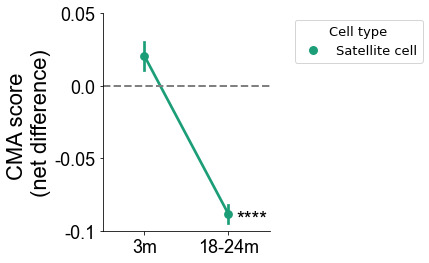

In [49]:
# CMA net score by cell type
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.pointplot(x='new_age', y='net_score', data=barcode, hue='new_cell', order=["3m", "18-24m"], 
              hue_order=cells, palette="Dark2", ci=68)
plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticklabels(["3m", "18-24m"], fontdict={'family':'Arial', 'size': 18})
plt.xlabel('')
plt.ylim(-0.10, 0.05) 
ax.set_yticks([-0.10, -0.05, 0.00, 0.05])
ax.set_yticklabels([-0.10, -0.05, 0.00, 0.05], fontdict={'family':'Arial', 'size': 18})

# Legend
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='#1b9e77', label='Satellite cell', 
                         markersize=10)]

plt.legend(handles=legend_elements, bbox_to_anchor = (1.95, 1), facecolor='white', title="Cell type", title_fontsize = "13", 
           fontsize=13)
                          
# Stats
x1= 1.1   
y1= np.mean(barcode[barcode.new_cell =='satellite cell'][barcode.new_age=='18-24m']['net_score']) -(0.008)
plt.text(x1, y1, "****", fontsize=20, **hfont)

plt.savefig('../Khwaja_et_al_outputs/Muscle/Musc_nscorrect.png',bbox_inches='tight', dpi=300)

plt.show()

### Raw data

In [50]:
# Extracting raw values for pointplot graphic
long = []
celula = []
age = []
mean=[]
sem=[]

for x in cells:
    for y in ['3m', '18-24m']:
        n = len(barcode[barcode['new_cell']== x][barcode['new_age']== y].index)
        m = np.mean(barcode[barcode['new_cell']== x][barcode['new_age']== y]['net_score'])
        s = stats.sem(np.array(barcode[barcode['new_cell']== x][barcode['new_age']== y]['net_score']))
        
        long.append(n)
        celula.append(x)
        age.append(y)
        mean.append(m)
        sem.append(s)
        
df_raw = pd.DataFrame({"Cell_type": celula, "Age": age, "n": long, "Mean":mean, "SEM": sem})
df_raw

C:\Users\Adrian\AppData\Local\Temp\ipykernel_6412\1532967860.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n = len(barcode[barcode['new_cell']== x][barcode['new_age']== y].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_6412\1532967860.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  m = np.mean(barcode[barcode['new_cell']== x][barcode['new_age']== y]['net_score'])
C:\Users\Adrian\AppData\Local\Temp\ipykernel_6412\1532967860.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  s = stats.sem(np.array(barcode[barcode['new_cell']== x][barcode['new_age']== y]['net_score']))


,Cell_type,Age,n,Mean,SEM
0,satellite cell,3m,535,0.020541,0.010097
1,satellite cell,18-24m,1298,-0.088136,0.006386


In [51]:
df_raw.to_excel('../Khwaja_et_al_outputs/Muscle/Raw_data.xlsx', 'Netsc', index=False)

## CMA net score/cell type & sex  (fold over whole tissue)

### Stats

In [52]:
# Calculating n of cells per cell type, sex and age
for i in cells:
    print(i.title() + " length:" + str(len(barcode[barcode["new_cell"]==i].index)))
    print(barcode[barcode["new_cell"]==i].value_counts(["sex", "new_age"]))
    print("\n")

Satellite Cell length:1833
sex     new_age
male    18-24m     762
female  18-24m     536
        3m         271
male    3m         264
dtype: int64




In [53]:
# 2-way Anova for all cells
for i in cells:
    intdf = barcode[barcode['new_cell']==i].reset_index()    
    
    # 2-way Anova
    model = ols('net_score ~ C(new_age) + C(sex) + C(new_age):C(sex)',data=intdf).fit()
    result = sm.stats.anova_lm(model, type=2)
    print(i.title()+' 2-way Anova\n')
    print(result)
    print('\n')
    
    # Post hocs multi comparissons Bonferroni
    interaction_groups = intdf.new_age.astype(str) + " & " + intdf.sex.astype(str)
    comp = mc.MultiComparison(intdf['net_score'], interaction_groups)
    tbl, a1, a2 = comp.allpairtest(stats.ttest_ind, method= "bonf")
    print(i.title()+' Post-Hoc Bonferroni\n')
    print(tbl)
    print('\n')

Satellite Cell 2-way Anova

                       df     sum_sq   mean_sq          F        PR(>F)
C(new_age)            1.0   4.474469  4.474469  84.625107  9.534638e-20
C(sex)                1.0   0.019444  0.019444   0.367736  5.443164e-01
C(new_age):C(sex)     1.0   1.045889  1.045889  19.780783  9.207303e-06
Residual           1829.0  96.706561  0.052874        NaN           NaN


Satellite Cell Post-Hoc Bonferroni

Test Multiple Comparison ttest_ind 
FWER=0.05 method=bonf
alphacSidak=0.01, alphacBonf=0.008
     group1         group2      stat   pval  pval_corr reject
-------------------------------------------------------------
18-24m & female 18-24m & male  2.9441 0.0033    0.0198   True
18-24m & female   3m & female -3.1136 0.0019    0.0115   True
18-24m & female     3m & male -6.7833    0.0       0.0   True
  18-24m & male   3m & female -5.7264    0.0       0.0   True
  18-24m & male     3m & male -9.6088    0.0       0.0   True
    3m & female     3m & male -3.3746 0.0008   

### Graphs

#### Satellite cell

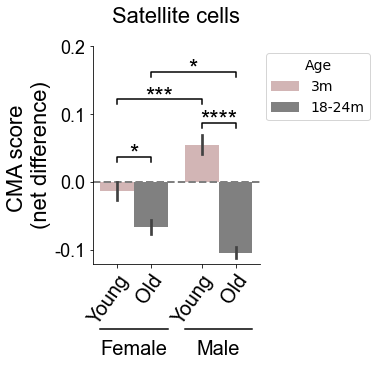

In [65]:
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='net_score', data=barcode[barcode.new_cell=='satellite cell'], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.12, 0.20)
ax.set_yticks([-0.10, 0.0, 0.10, 0.20])
ax.set_yticklabels([-0.10, 0.0, 0.10, 0.20], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Satellite cells', fontdict={'family':'Arial', 'size': 22}, y=1.08) 

# statistical annotation
x1, x2 = -0.2, 0.2   
y, h, col = 0.03 , 0.007, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y-h, "*", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

x1, x2 = 0.8, 1.2   
y, h, col = 0.08 , 0.007, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y-h, "****", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

x1, x2 = -.2, .8   
y, h, col = 0.115 , 0.007, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y-h, "***", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

x1, x2 = .2, 1.2   
y, h, col = 0.155 , 0.007, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y-h, "*", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig('../Khwaja_et_al_outputs/Muscle/Sat_ns_sex.png',bbox_inches='tight', dpi=300)

plt.show()

### Raw data

In [66]:
# Extracting raw values for bar graphs graphic
def raw (tipos, edad, sex):
    long = []
    celula = []
    age = []
    mean=[]
    sem=[]
    sexo = []

    for i in tipos:
        for x in edad:
            for y in sex:
                n = len(barcode[barcode['new_cell']== i][barcode['new_age']== x][barcode['sex']== y].index)
                m = np.mean(barcode[barcode['new_cell']== i][barcode['new_age']== x][barcode['sex']== y]['net_score'])
                s = stats.sem(barcode[barcode['new_cell']== i][barcode['new_age']== x][barcode['sex']== y]['net_score'])

                long.append(n)
                celula.append(i)                
                age.append(x)
                sexo.append(y)
                mean.append(m)
                sem.append(s)

    df_raw = pd.DataFrame({"Cell_type": celula, "Age": age, "Sex":sexo, "n": long, "Mean":mean, "SEM": sem})
    with pd.ExcelWriter("../Khwaja_et_al_outputs/Muscle/Raw_data.xlsx", mode="a", if_sheet_exists='replace', 
                        engine="openpyxl") as writer:
        df_raw.to_excel(writer, sheet_name="Nsbysex", index=False)
    return(df_raw)

In [67]:
raw(tipos = cells, edad=['3m', '18-24m'], sex=['female', 'male'])

C:\Users\Adrian\AppData\Local\Temp\ipykernel_6412\2738992050.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n = len(barcode[barcode['new_cell']== i][barcode['new_age']== x][barcode['sex']== y].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_6412\2738992050.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  m = np.mean(barcode[barcode['new_cell']== i][barcode['new_age']== x][barcode['sex']== y]['net_score'])
C:\Users\Adrian\AppData\Local\Temp\ipykernel_6412\2738992050.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  s = stats.sem(barcode[barcode['new_cell']== i][barcode['new_age']== x][barcode['sex']== y]['net_score'])


,Cell_type,Age,Sex,n,Mean,SEM
0,satellite cell,3m,female,271,-0.012767,0.013323
1,satellite cell,3m,male,264,0.054733,0.014955
2,satellite cell,18-24m,female,536,-0.065786,0.010061
3,satellite cell,18-24m,male,762,-0.103856,0.008218


## CMA net score/cell type & sex (fold over each cell type young)

In [68]:
# Calculation of net score (fold to 3m for each individual cell type)
for maj_cell in tqdm(np.unique(barcode['new_cell'])):
    
    µ = np.mean(barcode[barcode['new_cell'] == maj_cell][barcode['new_age'] == '3m']['score'])
    
    for cell_index in barcode[barcode['new_cell'] == maj_cell].index:
    
        barcode.loc[cell_index, 'celltype_ns'] = barcode.loc[cell_index, 'score'] - µ  

barcode.head()

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]C:\Users\Adrian\AppData\Local\Temp\ipykernel_6412\2122786486.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  µ = np.mean(barcode[barcode['new_cell'] == maj_cell][barcode['new_age'] == '3m']['score'])
C:\Users\Adrian\AppData\Local\Temp\ipykernel_6412\2122786486.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  µ = np.mean(barcode[barcode['new_cell'] == maj_cell][barcode['new_age'] == '3m']['score'])
100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.13it/s]


,FACS.selection,age,cell,free_annotation,method,mouse.id,subtissue,n_genes,n_counts,louvain,...,organism,sex,tissue,ethnicity,development_stage,score,new_age,new_cell,net_score,celltype_ns
index,,,,,,,,,,,,,,,,,,,,,
A10_B000927_B007456_S10.mm10-plus-0-0,"CD31+, CD45+, CD31-CD45-Sca1+, CD31-CD45-Sca1-...",18m,A10_B000927,nan,facs,18_46_F,Muscle Diaphragm,2789,2356.270020,1,...,Mus musculus,female,limb muscle,na,18 month-old stage,-0.211785,18-24m,satellite cell,-0.293106,-0.313647
A10_B003294_B007450_S10.mm10-plus-0-0,"CD31+, CD45+, CD31-CD45-Sca1+, CD31-CD45-Sca1-...",18m,A10_B003294,nan,facs,18_47_F,Muscle forelimb and hindlimb,1838,3657.208008,0,...,Mus musculus,female,limb muscle,na,18 month-old stage,0.084253,18-24m,satellite cell,0.002932,-0.017609
A11_B000927_B007456_S11.mm10-plus-0-0,"CD31+, CD45+, CD31-CD45-Sca1+, CD31-CD45-Sca1-...",18m,A11_B000927,nan,facs,18_46_F,Muscle Diaphragm,3198,2857.186279,7,...,Mus musculus,female,limb muscle,na,18 month-old stage,-0.027031,18-24m,satellite cell,-0.108351,-0.128893
A11_B003263_B007458_S11.mm10-plus-0-0,"CD31+, CD45+, CD31-CD45-Sca1+, CD31-CD45-Sca1-...",18m,A11_B003263,nan,facs,18_45_M,forelimb and hindlimb,1082,2264.398682,1,...,Mus musculus,male,limb muscle,na,18 month-old stage,0.134997,18-24m,satellite cell,0.053676,0.033135
A11_B003294_B007450_S11.mm10-plus-0-0,"CD31+, CD45+, CD31-CD45-Sca1+, CD31-CD45-Sca1-...",18m,A11_B003294,nan,facs,18_47_F,Muscle forelimb and hindlimb,1218,2633.463135,8,...,Mus musculus,female,limb muscle,na,18 month-old stage,-0.181882,18-24m,satellite cell,-0.263203,-0.283744


### Graphs

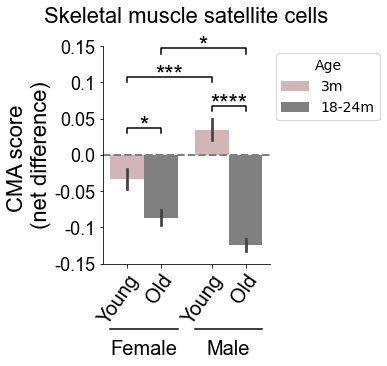

In [70]:
# Figure Satellite cells
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='celltype_ns', data=barcode[barcode.new_cell=='satellite cell'], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.15, 0.15)
ax.set_yticks([-0.15, -0.10, -0.05, 0.00, 0.05, 0.10, 0.15])
ax.set_yticklabels([-0.15, -0.10, -0.05, 0.00, 0.05, 0.10, 0.15], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Skeletal muscle satellite cells', fontdict={'family':'Arial', 'size': 22}, y=1.08)
 

# statistical annotation
x1, x2 = -0.2, 0.2   
y, h, col = 0.03 , 0.007, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y-h, "*", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

x1, x2 = 0.8, 1.2   
y, h, col = 0.06 , 0.007, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y-h, "****", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

x1, x2 = -.2, .8   
y, h, col = 0.10 , 0.007, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y-h, "***", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

x1, x2 = .2, 1.2   
y, h, col = 0.14 , 0.007, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y-h, "*", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})
 
# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)


plt.savefig('../Khwaja_et_al_outputs/Muscle/Sat_cellns_sex.png',bbox_inches='tight', dpi=300)

plt.show()

### Raw data

In [71]:
# Extracting raw values for bar graphs graphic
def raw (tipos, edad, sex):
    long = []
    celula = []
    age = []
    mean=[]
    sem=[]
    sexo = []

    for i in tipos:
        for x in edad:
            for y in sex:
                n = len(barcode[barcode['new_cell']== i][barcode['new_age']== x][barcode['sex']== y].index)
                m = np.mean(barcode[barcode['new_cell']== i][barcode['new_age']== x][barcode['sex']== y]['celltype_ns'])
                s = stats.sem(barcode[barcode['new_cell']== i][barcode['new_age']== x][barcode['sex']== y]['celltype_ns'])

                long.append(n)
                celula.append(i)                
                age.append(x)
                sexo.append(y)
                mean.append(m)
                sem.append(s)

    df_raw = pd.DataFrame({"Cell_type": celula, "Age": age, "Sex":sexo, "n": long, "Mean":mean, "SEM": sem})
    with pd.ExcelWriter("../Khwaja_et_al_outputs/Muscle/Raw_data.xlsx", mode="a", if_sheet_exists='replace', 
                        engine="openpyxl") as writer:
        df_raw.to_excel(writer, sheet_name="CellNsbysex", index=False)
    return(df_raw)

In [72]:
raw(tipos = cells, edad=['3m', '18-24m'], sex=['female', 'male'])

C:\Users\Adrian\AppData\Local\Temp\ipykernel_6412\3259260681.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n = len(barcode[barcode['new_cell']== i][barcode['new_age']== x][barcode['sex']== y].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_6412\3259260681.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  m = np.mean(barcode[barcode['new_cell']== i][barcode['new_age']== x][barcode['sex']== y]['celltype_ns'])
C:\Users\Adrian\AppData\Local\Temp\ipykernel_6412\3259260681.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  s = stats.sem(barcode[barcode['new_cell']== i][barcode['new_age']== x][barcode['sex']== y]['celltype_ns'])


,Cell_type,Age,Sex,n,Mean,SEM
0,satellite cell,3m,female,271,-0.033308,0.013323
1,satellite cell,3m,male,264,0.034191,0.014955
2,satellite cell,18-24m,female,536,-0.086328,0.010061
3,satellite cell,18-24m,male,762,-0.124398,0.008218


## CMA network heatmaps by cell type & sex

In [73]:
# Load matrix reordered
model_matrix = pd.read_excel('../Exp. 2_Tabula muris/activation_model.xlsx', 'reordered')

# Removing EEF1A1 and RAC1 because they don't appear in the adata
model_matrix = model_matrix.drop([6, 8], axis=0).reset_index()

# Mapping data from adata to new order of CMA network
cma_network = adata[:, model_matrix["Ensembl_ms"]]

In [74]:
def sex_heatmaps(cellpop):
    
    # Prepare empty matrix
    matrix = np.zeros((16, 4))
    
    #Find cell indices for each condition
    female_3m = list(barcode[barcode['new_cell'] == cellpop][barcode['sex'] == "female"][barcode['new_age'] == "3m"].index)
    female_18_24m = list(barcode[barcode['new_cell'] == cellpop][barcode['sex'] == "female"][barcode['new_age'] == "18-24m"].index)
    male_3m = list(barcode[barcode['new_cell'] == cellpop][barcode['sex'] == "male"][barcode['new_age'] == "3m"].index)
    male_18_24m = list(barcode[barcode['new_cell'] == cellpop][barcode['sex'] == "male"][barcode['new_age'] == "18-24m"].index)
    
    #Calculate mean per gene for every condition
    for rank in tqdm(np.arange(matrix.shape[0])):    
        matrix[rank, 0] = np.mean(cma_network[female_3m, :].X.todense()[:, rank])
        matrix[rank, 1] = np.mean(cma_network[female_18_24m, :].X.todense()[:, rank])
        matrix[rank, 2] = np.mean(cma_network[male_3m, :].X.todense()[:, rank])
        matrix[rank, 3] = np.mean(cma_network[male_18_24m, :].X.todense()[:, rank])
            
    #Perform z-scoring on each row
    matrix_zs = matrix.copy()

    for i in np.arange(matrix_zs.shape[0]):
    
        µ = np.mean(matrix_zs[i, :])
        sd = np.std(matrix_zs[i, :])
    
        matrix_zs[i, :] = (matrix_zs[i, :] - µ) / sd     
    
    # Saving raw data
    df_m = pd.DataFrame(matrix_zs, columns=['female_young', 'female_old', 'male_young', 'male_old'], 
                        index=model_matrix['Gene name'])
    with pd.ExcelWriter("../Khwaja_et_al_outputs/Muscle/Raw_data.xlsx", mode="a", if_sheet_exists='replace', 
                        engine="openpyxl") as writer:
        df_m.to_excel(writer, sheet_name=cellpop[:3]+'_heat', index=True)
        
    #Plot heatmap including all conditions
    fig, ax = plt.subplots(figsize=(6,6))
    hfont = {'fontname':'Arial'}

    plt.imshow(matrix_zs, cmap='viridis', vmin=-1.5, vmax=1.5)
    plt.colorbar(shrink=.5).set_label(label="Gene Z score", size=16, **hfont)

    plt.yticks(np.arange(16), model_matrix['Gene name'], fontsize=16, **hfont)

    plt.ylim(15.5, -0.5)

    plt.xticks(np.arange(4), ['3m', '18-24m', '3m', '18-24m'], rotation=55, ha='right', rotation_mode='anchor',fontsize=16, **hfont)
    plt.title(cellpop.title(), fontdict={'family':'Arial', 'size': 22}, y=1.05)

    plt.axvline(x=1.5, linestyle='dashed', linewidth=2, color='k', zorder=1)

    # Annotations
    trans = ax.get_yaxis_transform()
    trans2 = ax.get_xaxis_transform()
    ax.annotate('Effectors', xy=(-1.5, 0), xycoords=trans, ha='left', rotation=90, va="top", 
                color='k', size=16, **hfont)
    ax.plot([-1.25,-1.25],[-0.25, 4.25], color="k", transform=trans, clip_on=False)

    ax.annotate('Pos. regulators', xy=(-1.5, 4.75), xycoords=trans, ha='left', rotation=90, va="top", 
                color='green', size=16, **hfont)
    ax.plot([-1.25,-1.25],[4.75, 10.25], color="k", transform=trans, clip_on=False)

    ax.annotate('Neg. regulators', xy=(-1.5, 10.5), xycoords=trans, ha='left', rotation=90, va="top", 
                color='red', size=16, **hfont)
    ax.plot([-1.25,-1.25],[11, 15.25], color="k", transform=trans, clip_on=False)

    ax.annotate('Female', xy=(0.4, -.22), xycoords=trans2, ha="center", va="top", size=16, **hfont)
    ax.plot([-.5,1.25],[-.2,-.2], color="k", transform=trans2, clip_on=False)

    ax.annotate('Male', xy=(2.6, -.22), xycoords=trans2, ha="center", va="top", size=16, **hfont)
    ax.plot([1.5, 3.25],[-.2,-.2], color="k", transform=trans2, clip_on=False)
    
    plt.savefig('../Khwaja_et_al_outputs/Muscle/{}_heat.png'.format(cellpop[:3]),bbox_inches='tight', dpi=300)
    
    plt.show()

C:\Users\Adrian\AppData\Local\Temp\ipykernel_6412\3727705263.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  female_3m = list(barcode[barcode['new_cell'] == cellpop][barcode['sex'] == "female"][barcode['new_age'] == "3m"].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_6412\3727705263.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  female_18_24m = list(barcode[barcode['new_cell'] == cellpop][barcode['sex'] == "female"][barcode['new_age'] == "18-24m"].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_6412\3727705263.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  male_3m = list(barcode[barcode['new_cell'] == cellpop][barcode['sex'] == "male"][barcode['new_age'] == "3m"].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_6412\3727705263.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  male_18_24m = list(barcode[barcode['new_cell'] == cellp

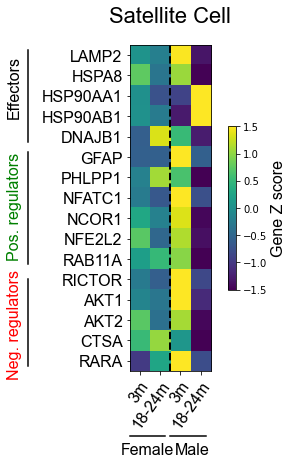

In [75]:
for i in cells:
    sex_heatmaps(cellpop=i)

## Ridge plots for L2 and L1

In [76]:
# Codes for L2 and L1
lys = ['ENSMUSG00000016534', 'ENSMUSG00000031447']

In [77]:
# Selecting only L2 and L1 from adata
adata_lys = adata[:, lys]
barcode_lys = adata.obs.copy()

# Calculating the Z score for L2 & L1
lys_zs = adata_lys.copy().X.todense()

for i in tqdm(np.arange(lys_zs.shape[1])):
    
    µ = np.mean(lys_zs[:, i])
    sd = np.std(lys_zs[:, i])
    
    lys_zs[:, i] = (lys_zs[:, i] - µ)/sd
    
# Converting lys_zs.X to a pandas df
df_lys = pd.DataFrame(lys_zs.tolist())
df_lys.rename(columns={0:"L2", 1:'L1'}, inplace=True)

# Generating barcode df and appending L2 column
barcode_lys = barcode_lys.reset_index()
barcode_lys = pd.concat([barcode_lys, df_lys], axis=1)
barcode_lys = barcode_lys [['index', 'cell', 'cell_type', 'sex', 'age', 'L2', 'L1']]

barcode_lys.head()

100%|████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<?, ?it/s]


,index,cell,cell_type,sex,age,L2,L1
0,A10_B000927_B007456_S10.mm10-plus-0-0,A10_B000927,skeletal muscle satellite cell,female,18m,-0.113012,-0.351594
1,A10_B003294_B007450_S10.mm10-plus-0-0,A10_B003294,skeletal muscle satellite cell,female,18m,1.157270,0.835163
2,A11_B000927_B007456_S11.mm10-plus-0-0,A11_B000927,skeletal muscle satellite cell,female,18m,-0.996626,1.000546
3,A11_B003263_B007458_S11.mm10-plus-0-0,A11_B003263,skeletal muscle satellite cell,male,18m,-0.996626,-1.306433
4,A11_B003294_B007450_S11.mm10-plus-0-0,A11_B003294,skeletal muscle satellite cell,female,18m,1.288743,-1.306433


In [79]:
# Generating new ages
for j in barcode_lys.index:    
    if barcode_lys.loc[j, 'age'] == '3m':        
        barcode_lys.loc[j, 'new_age'] = '3m'

    else:                
        barcode_lys.loc[j, 'new_age'] = '18-24m'

# Generating new cell types combining some of them
for j in tqdm(barcode_lys.index):    
    if barcode_lys.loc[j, 'cell_type'] == 'skeletal muscle satellite cell':        
        barcode_lys.loc[j, 'new_cell'] = 'satellite cell'
    
    else:                
        barcode_lys.loc[j, 'new_cell'] = barcode_lys.loc[j, 'cell_type']
     
barcode_lys.head()

100%|████████████████████████████████████████████████████████████████████████████| 3855/3855 [00:00<00:00, 6492.93it/s]


,index,cell,cell_type,sex,age,L2,L1,new_age,new_cell
0,A10_B000927_B007456_S10.mm10-plus-0-0,A10_B000927,skeletal muscle satellite cell,female,18m,-0.113012,-0.351594,18-24m,satellite cell
1,A10_B003294_B007450_S10.mm10-plus-0-0,A10_B003294,skeletal muscle satellite cell,female,18m,1.157270,0.835163,18-24m,satellite cell
2,A11_B000927_B007456_S11.mm10-plus-0-0,A11_B000927,skeletal muscle satellite cell,female,18m,-0.996626,1.000546,18-24m,satellite cell
3,A11_B003263_B007458_S11.mm10-plus-0-0,A11_B003263,skeletal muscle satellite cell,male,18m,-0.996626,-1.306433,18-24m,satellite cell
4,A11_B003294_B007450_S11.mm10-plus-0-0,A11_B003294,skeletal muscle satellite cell,female,18m,1.288743,-1.306433,18-24m,satellite cell


In [80]:
# Reducing df only to cells of interest
barcode_lys = barcode_lys[barcode_lys['new_cell'].isin(cells)]
print(barcode_lys.new_cell.unique())
barcode_lys.head()

['satellite cell']


,index,cell,cell_type,sex,age,L2,L1,new_age,new_cell
0,A10_B000927_B007456_S10.mm10-plus-0-0,A10_B000927,skeletal muscle satellite cell,female,18m,-0.113012,-0.351594,18-24m,satellite cell
1,A10_B003294_B007450_S10.mm10-plus-0-0,A10_B003294,skeletal muscle satellite cell,female,18m,1.157270,0.835163,18-24m,satellite cell
2,A11_B000927_B007456_S11.mm10-plus-0-0,A11_B000927,skeletal muscle satellite cell,female,18m,-0.996626,1.000546,18-24m,satellite cell
3,A11_B003263_B007458_S11.mm10-plus-0-0,A11_B003263,skeletal muscle satellite cell,male,18m,-0.996626,-1.306433,18-24m,satellite cell
4,A11_B003294_B007450_S11.mm10-plus-0-0,A11_B003294,skeletal muscle satellite cell,female,18m,1.288743,-1.306433,18-24m,satellite cell


### Graphs

#### Lamp2 female

C:\Users\Adrian\anaconda3\envs\scrna\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Adrian\anaconda3\envs\scrna\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Adrian\anaconda3\envs\scrna\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Adrian\anaconda3\envs\scrna\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layo

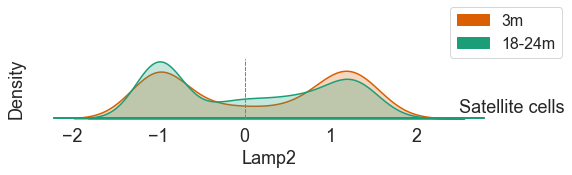

In [87]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), "axes.labelsize":18, "xtick.labelsize":18}, 
              font_scale=2)

g = sns.FacetGrid(barcode_lys[barcode_lys.sex == 'female'], row='new_cell', row_order = cells, hue='new_age', 
                  hue_order= ['3m', '18-24m'], aspect=7, height=1.1, palette=['#d95f02', '#1b9e77'])
g.map(sns.kdeplot, 'L2', bw_adjust=1, clip_on=False, fill=True, alpha=0.25, linewidth=1.5)
g.map(plt.axhline, y=0, lw=2, clip_on=False)
g.map(plt.axvline, x=0, lw=1, clip_on=False, color='gray', linestyle='dashed')

g.fig.subplots_adjust(hspace=0)

plt.text(x=2.5, y=0.06, s='Satellite cells', fontsize=18)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel='')
g.set(xlabel='Lamp2')
g.fig.text(0.04, 0.5, 'Density', va='center', rotation='vertical', fontsize=18)
g.despine(bottom=True, left=True)

# Legend
legend_elements = [Patch(facecolor='#d95f02', edgecolor='#d95f02', label='3m'),
                   Patch(facecolor='#1b9e77', edgecolor='#1b9e77', label='18-24m')]

plt.legend(handles=legend_elements, bbox_to_anchor = (1.2, 2), facecolor='white', fontsize=16)

plt.savefig('../Khwaja_et_al_outputs/Muscle/MuscL2_ridge_fem.png',bbox_inches='tight', dpi=300)
plt.show()

#### Lamp2 male

C:\Users\Adrian\anaconda3\envs\scrna\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Adrian\anaconda3\envs\scrna\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Adrian\anaconda3\envs\scrna\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Adrian\anaconda3\envs\scrna\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layo

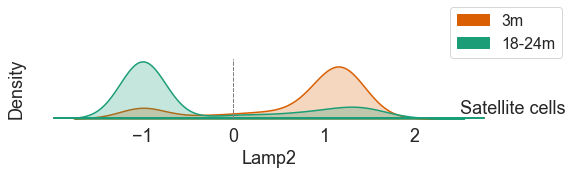

In [90]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), "axes.labelsize":18, "xtick.labelsize":18}, 
              font_scale=2)

g = sns.FacetGrid(barcode_lys[barcode_lys.sex == 'male'], row='new_cell', row_order = cells, hue='new_age', 
                  hue_order= ['3m', '18-24m'], aspect=7, height=1.1, palette=['#d95f02', '#1b9e77'])
g.map(sns.kdeplot, 'L2', bw_adjust=1, clip_on=False, fill=True, alpha=0.25, linewidth=1.5)
g.map(plt.axhline, y=0, lw=2, clip_on=False)
g.map(plt.axvline, x=0, lw=1, clip_on=False, color='gray', linestyle='dashed')

g.fig.subplots_adjust(hspace=0)

plt.text(x=2.5, y=0.1, s='Satellite cells', fontsize=18)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel='')
g.set(xlabel='Lamp2')
g.fig.text(0.04, 0.5, 'Density', va='center', rotation='vertical', fontsize=18)
g.despine(bottom=True, left=True)

# Legend
legend_elements = [Patch(facecolor='#d95f02', edgecolor='#d95f02', label='3m'),
                   Patch(facecolor='#1b9e77', edgecolor='#1b9e77', label='18-24m')]

plt.legend(handles=legend_elements, bbox_to_anchor = (1.2, 2), facecolor='white', fontsize=16)

plt.savefig('../Khwaja_et_al_outputs/Muscle/MuscL2_ridge_male.png',bbox_inches='tight', dpi=300)
plt.show()

#### Lamp1 female

C:\Users\Adrian\anaconda3\envs\scrna\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Adrian\anaconda3\envs\scrna\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Adrian\anaconda3\envs\scrna\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Adrian\anaconda3\envs\scrna\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layo

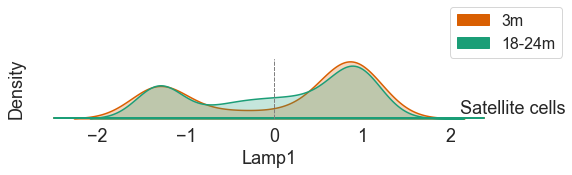

In [95]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), "axes.labelsize":18, "xtick.labelsize":18}, 
              font_scale=2)

g = sns.FacetGrid(barcode_lys[barcode_lys.sex == 'female'], row='new_cell', row_order = cells, hue='new_age', 
                  hue_order= ['3m', '18-24m'], aspect=7, height=1.1, palette=['#d95f02', '#1b9e77'])
g.map(sns.kdeplot, 'L1', bw_adjust=1, clip_on=False, fill=True, alpha=0.25, linewidth=1.5)
g.map(plt.axhline, y=0, lw=2, clip_on=False)
g.map(plt.axvline, x=0, lw=1, clip_on=False, color='gray', linestyle='dashed')

g.fig.subplots_adjust(hspace=0)

plt.text(x=2.1, y=0.06, s='Satellite cells', fontsize=18)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel='')
g.set(xlabel='Lamp1')
g.fig.text(0.04, 0.5, 'Density', va='center', rotation='vertical', fontsize=18)
g.despine(bottom=True, left=True)

# Legend
legend_elements = [Patch(facecolor='#d95f02', edgecolor='#d95f02', label='3m'),
                   Patch(facecolor='#1b9e77', edgecolor='#1b9e77', label='18-24m')]

plt.legend(handles=legend_elements, bbox_to_anchor = (1.2, 2), facecolor='white', fontsize=16)

plt.savefig('../Khwaja_et_al_outputs/Muscle/MuscL1_ridge_fem.png',bbox_inches='tight', dpi=300)
plt.show()

#### Lamp1 male

C:\Users\Adrian\anaconda3\envs\scrna\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Adrian\anaconda3\envs\scrna\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Adrian\anaconda3\envs\scrna\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Adrian\anaconda3\envs\scrna\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layo

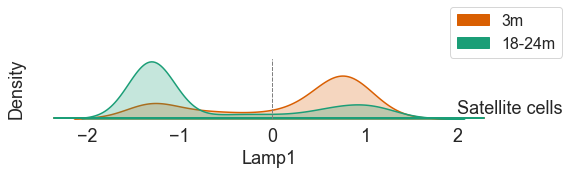

In [99]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), "axes.labelsize":18, "xtick.labelsize":18}, 
              font_scale=2)

g = sns.FacetGrid(barcode_lys[barcode_lys.sex == 'male'], row='new_cell', row_order = cells, hue='new_age', 
                  hue_order= ['3m', '18-24m'], aspect=7, height=1.1, palette=['#d95f02', '#1b9e77'])
g.map(sns.kdeplot, 'L1', bw_adjust=1, clip_on=False, fill=True, alpha=0.25, linewidth=1.5)
g.map(plt.axhline, y=0, lw=2, clip_on=False)
g.map(plt.axvline, x=0, lw=1, clip_on=False, color='gray', linestyle='dashed')

g.fig.subplots_adjust(hspace=0)

plt.text(x=2, y=0.09, s='Satellite cells', fontsize=18)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel='')
g.set(xlabel='Lamp1')
g.fig.text(0.04, 0.5, 'Density', va='center', rotation='vertical', fontsize=18)
g.despine(bottom=True, left=True)

# Legend
legend_elements = [Patch(facecolor='#d95f02', edgecolor='#d95f02', label='3m'),
                   Patch(facecolor='#1b9e77', edgecolor='#1b9e77', label='18-24m')]

plt.legend(handles=legend_elements, bbox_to_anchor = (1.2, 2), facecolor='white', fontsize=16)

plt.savefig('../Khwaja_et_al_outputs/Muscle/MuscL1_ridge_male.png',bbox_inches='tight', dpi=300)
plt.show()

## L2 Bar graphs

### Stats

In [100]:
# 2-way Anova for all cells
for i in cells:
    intdf = barcode_lys[barcode_lys['new_cell']==i].reset_index(drop=True)    
    
    # 2-way Anova
    model = ols('L2 ~ C(new_age) + C(sex) + C(new_age):C(sex)',data=intdf).fit()
    result = sm.stats.anova_lm(model, type=2)
    print(i.title()+' 2-way Anova\n')
    print(result)
    print('\n')
    
    # Post hocs multi comparissons Bonferroni
    interaction_groups = intdf.new_age.astype(str) + " & " + intdf.sex.astype(str)
    comp = mc.MultiComparison(intdf['L2'], interaction_groups)
    tbl, a1, a2 = comp.allpairtest(stats.ttest_ind, method= "bonf")
    print(i.title()+' Post-Hoc Bonferroni\n')
    print(tbl)
    print('\n')

Satellite Cell 2-way Anova

                       df       sum_sq     mean_sq           F        PR(>F)
C(new_age)            1.0   168.405539  168.405539  191.964572  1.382655e-41
C(sex)                1.0     9.692559    9.692559   11.048496  9.051173e-04
C(new_age):C(sex)     1.0   104.537992  104.537992  119.162297  6.400267e-27
Residual           1829.0  1604.534251    0.877274         NaN           NaN


Satellite Cell Post-Hoc Bonferroni

Test Multiple Comparison ttest_ind 
FWER=0.05 method=bonf
alphacSidak=0.01, alphacBonf=0.008
     group1         group2      stat    pval  pval_corr reject
--------------------------------------------------------------
18-24m & female 18-24m & male   8.6102    0.0       0.0   True
18-24m & female   3m & female   -1.406 0.1601    0.9606  False
18-24m & female     3m & male -10.2439    0.0       0.0   True
  18-24m & male   3m & female  -8.3041    0.0       0.0   True
  18-24m & male     3m & male -17.9936    0.0       0.0   True
    3m & female

### Graphs

In [101]:
sns.reset_defaults()

#### Satellite cells

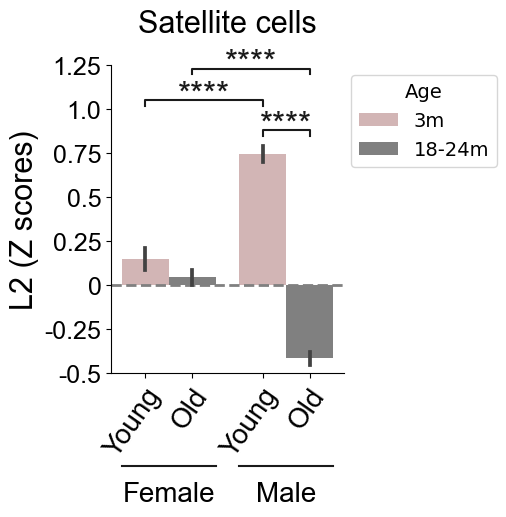

In [118]:
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='L2', data=barcode_lys[barcode_lys.new_cell=='satellite cell'], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('L2 (Z scores)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.5, 1.25)
ax.set_yticks([-0.5, -0.25, 0, 0.25, 0.50, 0.75, 1.0, 1.25])
ax.set_yticklabels([-0.5, -0.25, 0, 0.25, 0.50, 0.75, 1.0, 1.25], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14, 
          facecolor='white')
plt.title(label='Satellite cells', fontdict={'family':'Arial', 'size': 22}, y=1.08) 

# statistical annotation
x1, x2 = 0.8, 1.2   
y, h, col = 0.85 , 0.03, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y-h, "****", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

x1, x2 = -.2, .8   
y, h, col = 1.02 , 0.03, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y-h, "****", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

x1, x2 = .2, 1.2   
y, h, col = 1.2 , 0.03, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y-h, "****", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig('../Khwaja_et_al_outputs/Muscle/Sat_L2_sex.png',bbox_inches='tight', dpi=300)

plt.show()

### Raw data

In [119]:
# Extracting raw values for bar graphs graphic
def raw (tipos, edad, sex):
    long = []
    celula = []
    age = []
    mean=[]
    sem=[]
    sexo = []

    for i in tipos:
        for x in edad:
            for y in sex:
                n = len(barcode_lys[barcode_lys['new_cell']== i][barcode_lys['new_age']== x][barcode_lys['sex']== y].index)
                m = np.mean(barcode_lys[barcode_lys['new_cell']== i][barcode_lys['new_age']== x][barcode_lys['sex']== y]['L2'])
                s = stats.sem(barcode_lys[barcode_lys['new_cell']== i][barcode_lys['new_age']== x][barcode_lys['sex']== y]['L2'])

                long.append(n)
                celula.append(i)                
                age.append(x)
                sexo.append(y)
                mean.append(m)
                sem.append(s)

    df_raw = pd.DataFrame({"Cell_type": celula, "Age": age, "Sex":sexo, "n": long, "Mean":mean, "SEM": sem})
    with pd.ExcelWriter("../Khwaja_et_al_outputs/Muscle/Raw_data.xlsx", mode="a", if_sheet_exists='replace', 
                        engine="openpyxl") as writer:
        df_raw.to_excel(writer, sheet_name="L2bysex", index=False)
    return(df_raw)

In [120]:
raw(tipos = cells, edad=['3m', '18-24m'], sex=['female', 'male'])

C:\Users\Adrian\AppData\Local\Temp\ipykernel_6412\780749180.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n = len(barcode_lys[barcode_lys['new_cell']== i][barcode_lys['new_age']== x][barcode_lys['sex']== y].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_6412\780749180.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  m = np.mean(barcode_lys[barcode_lys['new_cell']== i][barcode_lys['new_age']== x][barcode_lys['sex']== y]['L2'])
C:\Users\Adrian\AppData\Local\Temp\ipykernel_6412\780749180.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  s = stats.sem(barcode_lys[barcode_lys['new_cell']== i][barcode_lys['new_age']== x][barcode_lys['sex']== y]['L2'])


,Cell_type,Age,Sex,n,Mean,SEM
0,satellite cell,3m,female,271,0.149378,0.061421
1,satellite cell,3m,male,264,0.743018,0.047313
2,satellite cell,18-24m,female,536,0.046693,0.041621
3,satellite cell,18-24m,male,762,-0.415104,0.034151
